## Введение в сверточные нейронные сети (CNN) для классификации изображений.

---



**Цель:**  
Научиться основам построения и обучения модели CNN для классификации изображений, используя PyTorch. Изучить архитектуру CNN, включая сверточные слои, пулинг и активационные функции.  


**План работы:**
1.	Изучить базовую архитектуру CNN и её компоненты.
2.	Подготовить датасет CIFAR-10 для классификации изображений.
3.	Определить архитектуру сети с использованием сверточных и пулинг слоев.
4.	Обучить модель и оценить её точность.


Задачи:
1.	Загрузить датасет CIFAR-10, выполнить нормализацию и подготовить данные для обучения.
2.	Определить архитектуру сети с двумя сверточными слоями, пулингом и полносвязными слоями.
3.	Написать тренировочный цикл, запустить обучение и отслеживать точность на обучающей и тестовой выборках.
4.	Визуализировать функцию потерь и оценить точность, объяснив, какие улучшения можно внести для повышения производительности.


---




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR, ReduceLROnPlateau, StepLR
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [ ]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

### Подготовка данных

In [ ]:
# Трансформации для нормализации изображений
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Загрузка тренировочного и тестового наборов данных
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Создание загрузчиков данных
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

### Определение базовой архитектуры CNN

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # 64 каналов на выходе после второго пулинга
        self.fc2 = nn.Linear(128, 10)          # 10 классов для CIFAR-10

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Инициализация модели
model = SimpleCNN()

# Настройка функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Тренировочный цикл

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
num_epochs = 10
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_losses.append(running_loss / len(train_loader))
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)
    print(f"Эпоха {epoch+1}/{num_epochs}, Потеря на обучении: {train_losses[-1]:.4f}, Точность на обучении: {train_accuracy:.2f}%")

    # Оценка на тестовых данных
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_losses.append(running_loss / len(test_loader))
    test_accuracy = 100 * correct / total
    test_accuracies.append(test_accuracy)
    print(f"Потеря на тестовом наборе: {test_losses[-1]:.4f}, Точность на тестовом наборе: {test_accuracy:.2f}%")

Эпоха 1/10, Потеря на обучении: 1.3108, Точность на обучении: 53.03%
Потеря на тестовом наборе: 1.1049, Точность на тестовом наборе: 60.73%
Эпоха 2/10, Потеря на обучении: 0.9442, Точность на обучении: 66.50%
Потеря на тестовом наборе: 0.9121, Точность на тестовом наборе: 67.72%
Эпоха 3/10, Потеря на обучении: 0.7911, Точность на обучении: 72.19%
Потеря на тестовом наборе: 0.8478, Точность на тестовом наборе: 70.14%
Эпоха 4/10, Потеря на обучении: 0.6760, Точность на обучении: 76.19%
Потеря на тестовом наборе: 0.8753, Точность на тестовом наборе: 70.74%
Эпоха 5/10, Потеря на обучении: 0.5809, Точность на обучении: 79.50%
Потеря на тестовом наборе: 0.8642, Точность на тестовом наборе: 71.01%
Эпоха 6/10, Потеря на обучении: 0.4882, Точность на обучении: 82.69%
Потеря на тестовом наборе: 0.8910, Точность на тестовом наборе: 71.43%
Эпоха 7/10, Потеря на обучении: 0.4080, Точность на обучении: 85.55%
Потеря на тестовом наборе: 0.9797, Точность на тестовом наборе: 70.69%
Эпоха 8/10, Потеря н

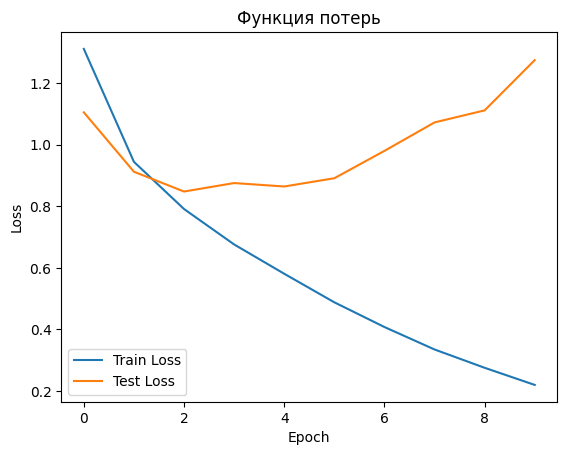

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Функция потерь')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

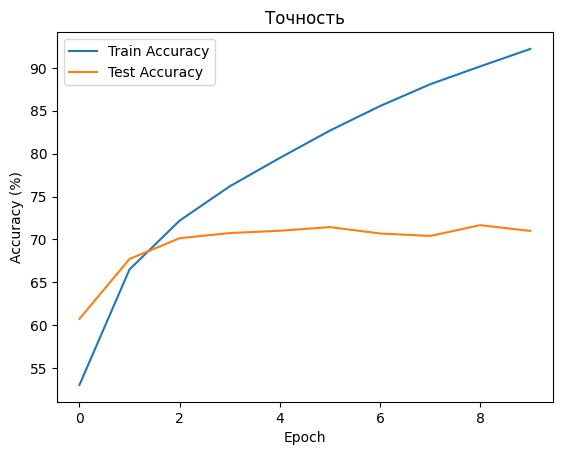

In [ ]:
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Точность')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend();

Рост точности и снижение потерь на обучающей выборке указывает на то, что CNN обучается успешно, однако на тестовом наборе данных видим рост функции потерь и более низкую точность, что свидетельсвует о том, что модель начинает переобучаться.  

Для предотвращения этой проблемы и повышения производительности модели можно прибегнуть к следующим методам:  
- Изменение архитектуры слоев;  
- Регуляризация (Dropout);  
- Batch Normalization;  
- Аугментация данных;  
- Оптимизация гиперпараметров.


## Классификация изображений с предобработкой и аугментацией данных.

---



**Цель:**  
Понять влияние предобработки и аугментации данных на работу модели CNN. Изучить, как различные типы данных и аугментация помогают модели обобщать на разных выборках, таких как CIFAR-10, Fashion-MNIST и SVHN.  

**План работы:**
1.	Подготовить данные из нескольких датасетов, применить разные методы аугментации (горизонтальное отражение, повороты, яркость).
2.	Обучить модель на каждом наборе данных и сравнить результаты.
3.	Проанализировать, как аугментация влияет на обобщающую способность модели.  

**Задачи:**
1.	Загрузить и предобработать CIFAR-10, Fashion-MNIST и SVHN, применяя различные техники аугментации.
2.	Обучить модель CNN на каждом из датасетов, сравнить точность и функцию потерь.
3.	Оценить влияние аугментации на результат и описать, какие методы лучше подходят для каждого датасета.
4.	Сделать выводы о том, как предобработка помогает улучшить обобщающие способности модели.


---



### CIFAR-10


Обучение на CIFAR-10, аугментация: без аугментации
Эпоха 1, Потери (train): 1.357, Точность (train): 51.01%, Потери (test): 1.095, Точность (test): 61.52%
Эпоха 2, Потери (train): 0.988, Точность (train): 65.10%, Потери (test): 0.934, Точность (test): 67.33%
Эпоха 3, Потери (train): 0.834, Точность (train): 70.81%, Потери (test): 0.886, Точность (test): 69.28%
Эпоха 4, Потери (train): 0.721, Точность (train): 74.78%, Потери (test): 0.856, Точность (test): 70.15%
Эпоха 5, Потери (train): 0.628, Точность (train): 77.94%, Потери (test): 0.887, Точность (test): 70.11%
Эпоха 6, Потери (train): 0.543, Точность (train): 80.97%, Потери (test): 0.885, Точность (test): 70.47%
Эпоха 7, Потери (train): 0.462, Точность (train): 83.88%, Потери (test): 0.899, Точность (test): 71.26%
Эпоха 8, Потери (train): 0.390, Точность (train): 86.21%, Потери (test): 1.007, Точность (test): 69.99%
Эпоха 9, Потери (train): 0.321, Точность (train): 88.73%, Потери (test): 1.018, Точность (test): 71.27%
Эпоха 10, По

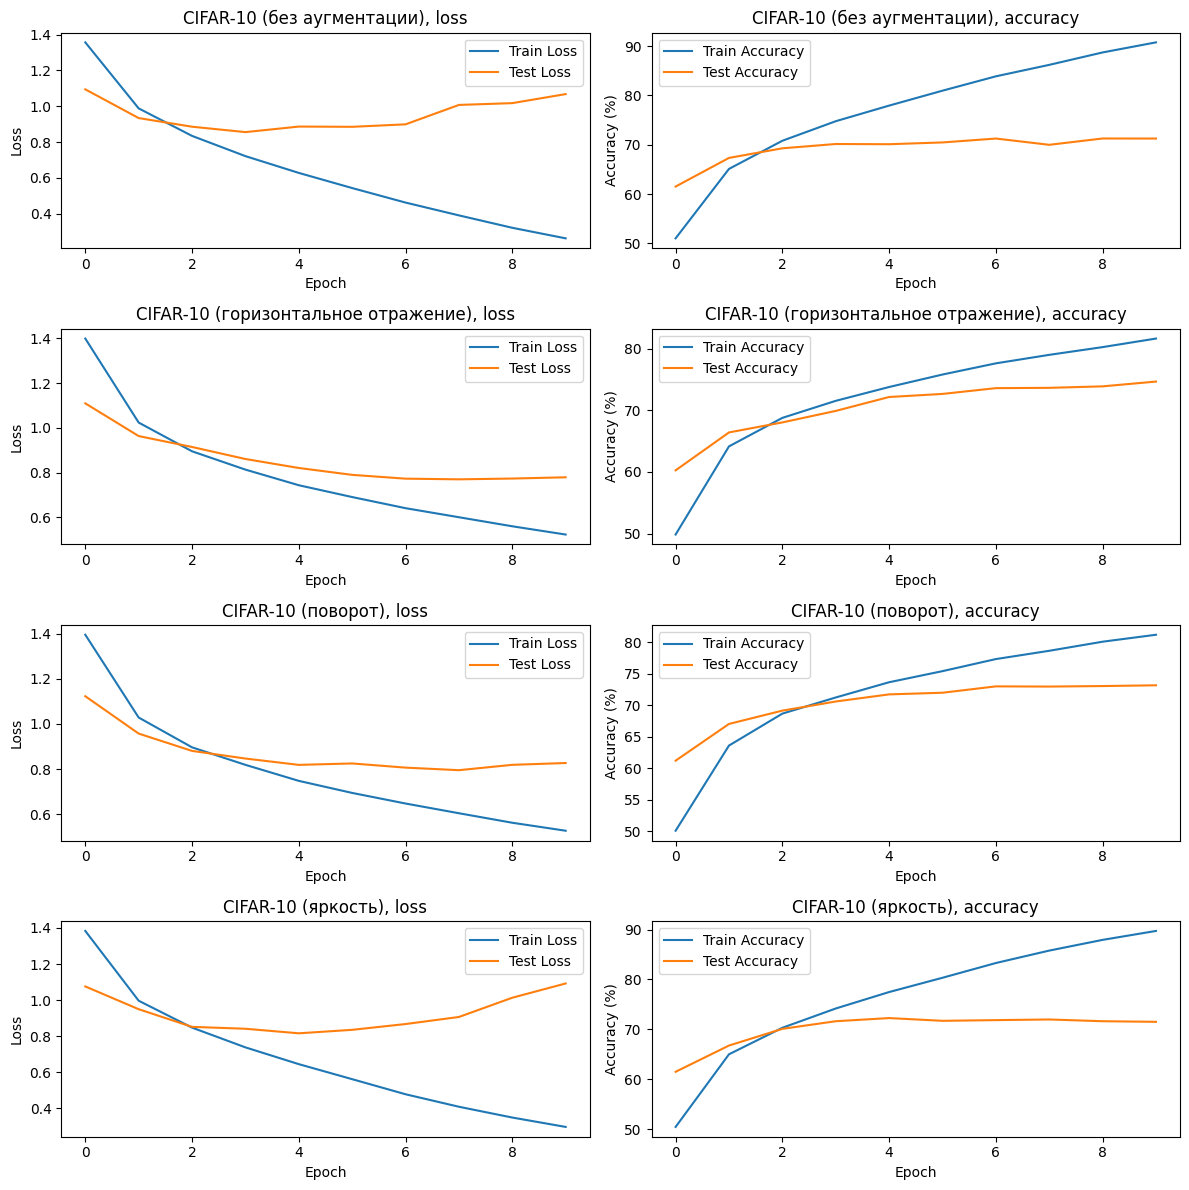

In [ ]:
# Определение пайплайна для аугментации изображений
def get_transforms(augmentation):
    if augmentation == 'без аугментации':
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    elif augmentation == 'горизонтальное отражение':
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    elif augmentation == 'поворот':
        train_transform = transforms.Compose([
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    elif augmentation == 'яркость':
        train_transform = transforms.Compose([
            transforms.ColorJitter(brightness=0.5),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    return train_transform, test_transform

# Загрузка и подготовка датасета CIFAR-10
def load_dataset(train_transform, test_transform):
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)
    return trainloader, testloader

# Определение архитектуры сети
class SimpleCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # 64 каналов на выходе после второго пулинга
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Тренировочный цикл
def train_model(net, trainloader, testloader, criterion, optimizer, device, num_epochs=10):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Оценка на тестовой выборке
        net.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for data in testloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_loss = test_loss / len(testloader)
        test_accuracy = 100 * correct / total
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Эпоха {epoch + 1}, Потери (train): {train_loss:.3f}, Точность (train): {train_accuracy:.2f}%, Потери (test): {test_loss:.3f}, Точность (test): {test_accuracy:.2f}%')

    # Вычисление метрик
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Вероятности классов лля roc_auc_score
    net.eval()
    all_probs = []
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs = inputs.to(device)
            outputs = net(inputs)
            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())

    all_probs = np.array(all_probs)
    roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')

    metrics = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

    return train_losses, test_losses, train_accuracies, test_accuracies, metrics

# Основная функция для CIFAR-10
def main():
    augmentations = ['без аугментации', 'горизонтальное отражение', 'поворот', 'яркость']
    results = {}

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    for augmentation in augmentations:
        print('\nОбучение на CIFAR-10, аугментация:', augmentation)

        train_transform, test_transform = get_transforms(augmentation)
        trainloader, testloader = load_dataset(train_transform, test_transform)

        input_channels = 3
        num_classes = 10

        net = SimpleCNN(input_channels, num_classes)
        net.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=0.001)

        train_losses, test_losses, train_accuracies, test_accuracies, metrics = train_model(net, trainloader, testloader, criterion, optimizer, device)

        results[augmentation] = {
            'train_losses': train_losses,
            'test_losses': test_losses,
            'train_accuracies': train_accuracies,
            'test_accuracies': test_accuracies,
            'metrics': metrics
        }

    # Вывод метрик
    print("\nМетрики для CIFAR-10:")
    for augmentation in augmentations:
        print(f"аугментация: {augmentation}")
        metrics = results[augmentation]['metrics']
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1 Score: {metrics['f1']:.4f}")
        print(f"ROC AUC Score: {metrics['roc_auc']:.4f}")

    # Визуализация результатов
    plt.figure(figsize=(12, 12))
    num_augmentations = len(augmentations)

    for j, augmentation in enumerate(augmentations):
        plt.subplot(num_augmentations, 2, j * 2 + 1)
        plt.plot(results[augmentation]['train_losses'], label='Train Loss')
        plt.plot(results[augmentation]['test_losses'], label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'CIFAR-10 ({augmentation}), loss')
        plt.legend()

        plt.subplot(num_augmentations, 2, j * 2 + 2)
        plt.plot(results[augmentation]['train_accuracies'], label='Train Accuracy')
        plt.plot(results[augmentation]['test_accuracies'], label='Test Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title(f'CIFAR-10 ({augmentation}), accuracy')
        plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

**Без аугментации** наблюдается **переобучение** модели: потери на тестовой выборке растут, а точность (71,26%) существенно ниже, чем на обучающей (90,78%).  

**Горизонтальное отражение** показало **наилучший результат**: accuracy = 74,7%, а потери на тестовом наборе данных наименьшие среди рассматриваемых вариантов, помимо этого метрики precision, recall, F1 score и ROC-AUC у данной модели так же наиболее высокие.  

**Поворот** повысил точность (73,14%) на 1,88 п.п. по сравнению с моделью без аугментации данных. Precision, recall, F1 score и ROC-AUC выше, чем без аугментации, но ниже, чем при горизонтальном отражении.  

**Изменение яркости** увеличило accuracy (71.52%) на 0,26 п.п., функция потерь изменилась несущественно, precision, recall, F1 score и ROC-AUC также немного выше чем у CNN без аугментации, но наименьшие среди моделей с аугментацией данных.   

Таким образом, на наборе данных CIFAR-10 **наиболее эффективным методом аугментации является горизонтальное отражение**, все метрики качества показали наилучший результат, а точность на тестовой выборке наиболее близка к значению, полученному на тренировочной. **CNN без аугментации данных** по каждому критерию **уступает по качеству всем прочим моделям**.  

### Fashion-MNIST


Обучение на MNIST, аугментация: без аугментации
Эпоха 1, Потери (train): 0.162, Точность (train): 94.99%, Потери (test): 0.052, Точность (test): 98.28%
Эпоха 2, Потери (train): 0.047, Точность (train): 98.60%, Потери (test): 0.031, Точность (test): 98.85%
Эпоха 3, Потери (train): 0.032, Точность (train): 99.00%, Потери (test): 0.029, Точность (test): 99.11%
Эпоха 4, Потери (train): 0.023, Точность (train): 99.27%, Потери (test): 0.028, Точность (test): 99.10%
Эпоха 5, Потери (train): 0.018, Точность (train): 99.44%, Потери (test): 0.028, Точность (test): 99.15%
Эпоха 6, Потери (train): 0.014, Точность (train): 99.50%, Потери (test): 0.025, Точность (test): 99.18%
Эпоха 7, Потери (train): 0.011, Точность (train): 99.63%, Потери (test): 0.030, Точность (test): 99.08%
Эпоха 8, Потери (train): 0.009, Точность (train): 99.70%, Потери (test): 0.029, Точность (test): 99.11%
Эпоха 9, Потери (train): 0.010, Точность (train): 99.68%, Потери (test): 0.032, Точность (test): 99.18%
Эпоха 10, Потер

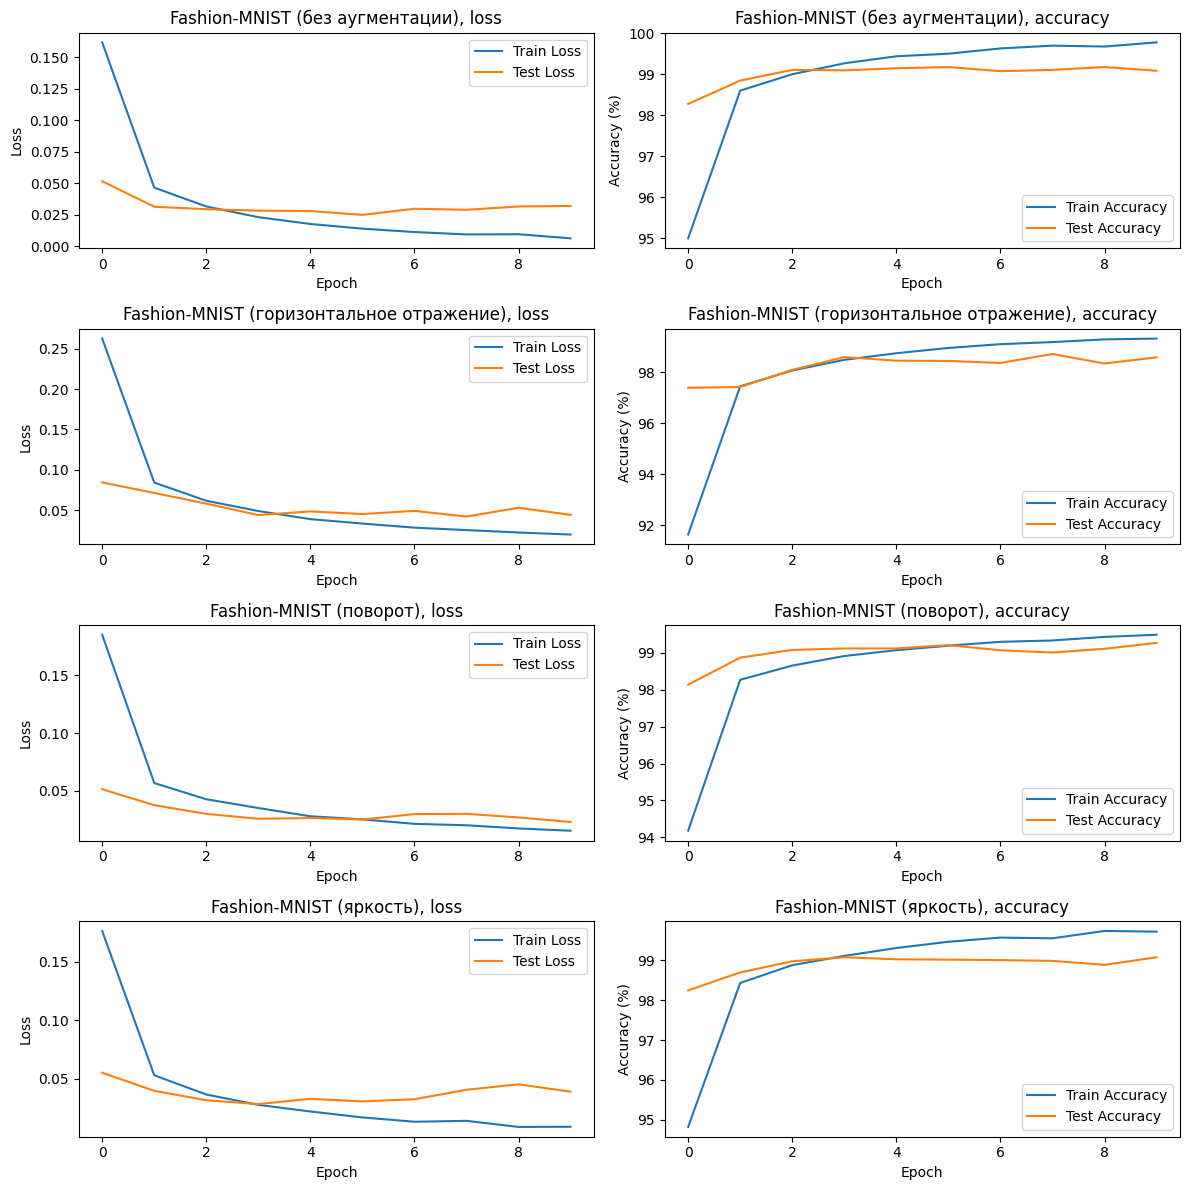

In [ ]:
# Определение пайплайна для аугментации изображений
def get_transforms(augmentation):
    if augmentation == 'без аугментации':
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
    elif augmentation == 'горизонтальное отражение':
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
    elif augmentation == 'поворот':
        train_transform = transforms.Compose([
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
    elif augmentation == 'яркость':
        train_transform = transforms.Compose([
            transforms.ColorJitter(brightness=0.5),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    return train_transform, test_transform

#Загрузка датасета
def load_dataset(train_transform, test_transform):
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=test_transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2, drop_last=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2, drop_last=True)

    return trainloader, testloader

# Определение архитектуры сети
class SimpleCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # 64 каналов на выходе после второго пулинга
        self.fc2 = nn.Linear(128, num_classes)
        #self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        #x = self.dropout(torch.relu(self.fc1(x)))
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Тренировочный цикл
def train_model(net, trainloader, testloader, criterion, optimizer, device, num_epochs=10):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Оценка на тестовой выборке
        net.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for data in testloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_loss = test_loss / len(testloader)
        test_accuracy = 100 * correct / total
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Эпоха {epoch + 1}, Потери (train): {train_loss:.3f}, Точность (train): {train_accuracy:.2f}%, Потери (test): {test_loss:.3f}, Точность (test): {test_accuracy:.2f}%')

    # Вычисление метрик
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Вероятности классов для roc_auc_score
    net.eval()
    all_probs = []
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs = inputs.to(device)
            outputs = net(inputs)
            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())

    all_probs = np.array(all_probs)
    roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')

    metrics = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

    return train_losses, test_losses, train_accuracies, test_accuracies, metrics

# Основная функция для MNIST
def main():
    augmentations = ['без аугментации', 'горизонтальное отражение', 'поворот', 'яркость']
    results = {}

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    for augmentation in augmentations:
        print('\nОбучение на MNIST, аугментация:', augmentation)

        train_transform, test_transform = get_transforms(augmentation)
        trainloader, testloader = load_dataset(train_transform, test_transform)

        input_channels = 1
        num_classes = 10

        net = SimpleCNN(input_channels, num_classes)
        net.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=0.001)

        train_losses, test_losses, train_accuracies, test_accuracies, metrics = train_model(net, trainloader, testloader, criterion, optimizer, device)

        results[augmentation] = {
            'train_losses': train_losses,
            'test_losses': test_losses,
            'train_accuracies': train_accuracies,
            'test_accuracies': test_accuracies,
            'metrics': metrics
        }

    # Вывод метрик
    print("\nМетрики для MNIST:")
    for augmentation in augmentations:
        print(f"Аугментация: {augmentation}")
        metrics = results[augmentation]['metrics']
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1 Score: {metrics['f1']:.4f}")
        print(f"ROC AUC Score: {metrics['roc_auc']:.4f}")

    # Визуализация результатов
    plt.figure(figsize=(12, 12))
    num_augmentations = len(augmentations)

    for j, augmentation in enumerate(augmentations):
        plt.subplot(num_augmentations, 2, j * 2 + 1)  # 2 столбца
        plt.plot(results[augmentation]['train_losses'], label='Train Loss')
        plt.plot(results[augmentation]['test_losses'], label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Fashion-MNIST ({augmentation}), loss')
        plt.legend()

        plt.subplot(num_augmentations, 2, j * 2 + 2)  # 2 столбца
        plt.plot(results[augmentation]['train_accuracies'], label='Train Accuracy')
        plt.plot(results[augmentation]['test_accuracies'], label='Test Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title(f'Fashion-MNIST ({augmentation}), accuracy')
        plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

На наборе данных Fashion-MNIST CNN **без аугментации** показала **один из наилучших результатов**: accuracy на тестовой выборке составила 99,09%, precision - 0.9909, recall - 0.9909, F1 score - 0.9909 и ROC-AUC - 1. При этом **применение поворота слегка улучшает обобщающую способность модели** - точность возрастает до 99,27%; незначительно, но всё же увеличиваются метрики precision - 0.9927, recall 0.9927 и F1 Score 0.9927, ROC_AUC так же 1. Потери у CNN с поворотом (0,023) немного ниже, чем у модели без аугментации (0,032).  
**Горизонтальный повотор** (98,58%) и **изменение яркости** (99,08%) несколько **сократили точность** на тестовом наборе данных, хоть и показали по-прежнему высокое качество. Precision, recall, F1 score и ROC_AUC тоже минимально сократились. Потери чуть выше, чем у CNN без аугментации и с применением поворота: 0,044 для горизонтального отражения и 0,039 для яркости.  

Таким образом, на Fashion-MNIST модель без аугментации данных весьма эффективно обучается и обобщается без дополнительных манипуляций (вероятно, по причине высокого качества и однородности данных, которые к тому же имеют вполне четкие и различимые классы). Однако поворот, хоть и несущественно, но всё же повышает качество модели. Такая аугментация может улучшить обобщающую способность CNN в реальных условиях, когда изображения могут быть представлены, например, под разными углами. По этой причине **я отдала бы препочтение модели с применением поворота.**

А вот горизонтальный поворот и изменение яркости могут существеннл исказить важные визуальные характеристики одежды, поэтому для Fashion-MNIST эти варианты аугментации я бы применять не стала.


### SVHN


Обучение на SVHN, аугментация: без аугментации


100%|██████████| 182M/182M [00:02<00:00, 84.6MB/s]
100%|██████████| 64.3M/64.3M [00:01<00:00, 52.0MB/s]


Эпоха 1, Потери (train): 0.885, Точность (train): 71.90%, Потери (test): 0.559, Точность (test): 84.23%
Эпоха 2, Потери (train): 0.525, Точность (train): 84.38%, Потери (test): 0.455, Точность (test): 86.68%
Эпоха 3, Потери (train): 0.453, Точность (train): 86.27%, Потери (test): 0.413, Точность (test): 88.05%
Эпоха 4, Потери (train): 0.409, Точность (train): 87.48%, Потери (test): 0.396, Точность (test): 88.16%
Эпоха 5, Потери (train): 0.379, Точность (train): 88.34%, Потери (test): 0.366, Точность (test): 89.27%
Эпоха 6, Потери (train): 0.355, Точность (train): 89.20%, Потери (test): 0.365, Точность (test): 89.49%
Эпоха 7, Потери (train): 0.334, Точность (train): 89.66%, Потери (test): 0.359, Точность (test): 89.56%
Эпоха 8, Потери (train): 0.317, Точность (train): 90.18%, Потери (test): 0.351, Точность (test): 89.71%
Эпоха 9, Потери (train): 0.306, Точность (train): 90.56%, Потери (test): 0.344, Точность (test): 90.09%
Эпоха 10, Потери (train): 0.291, Точность (train): 90.84%, Потер

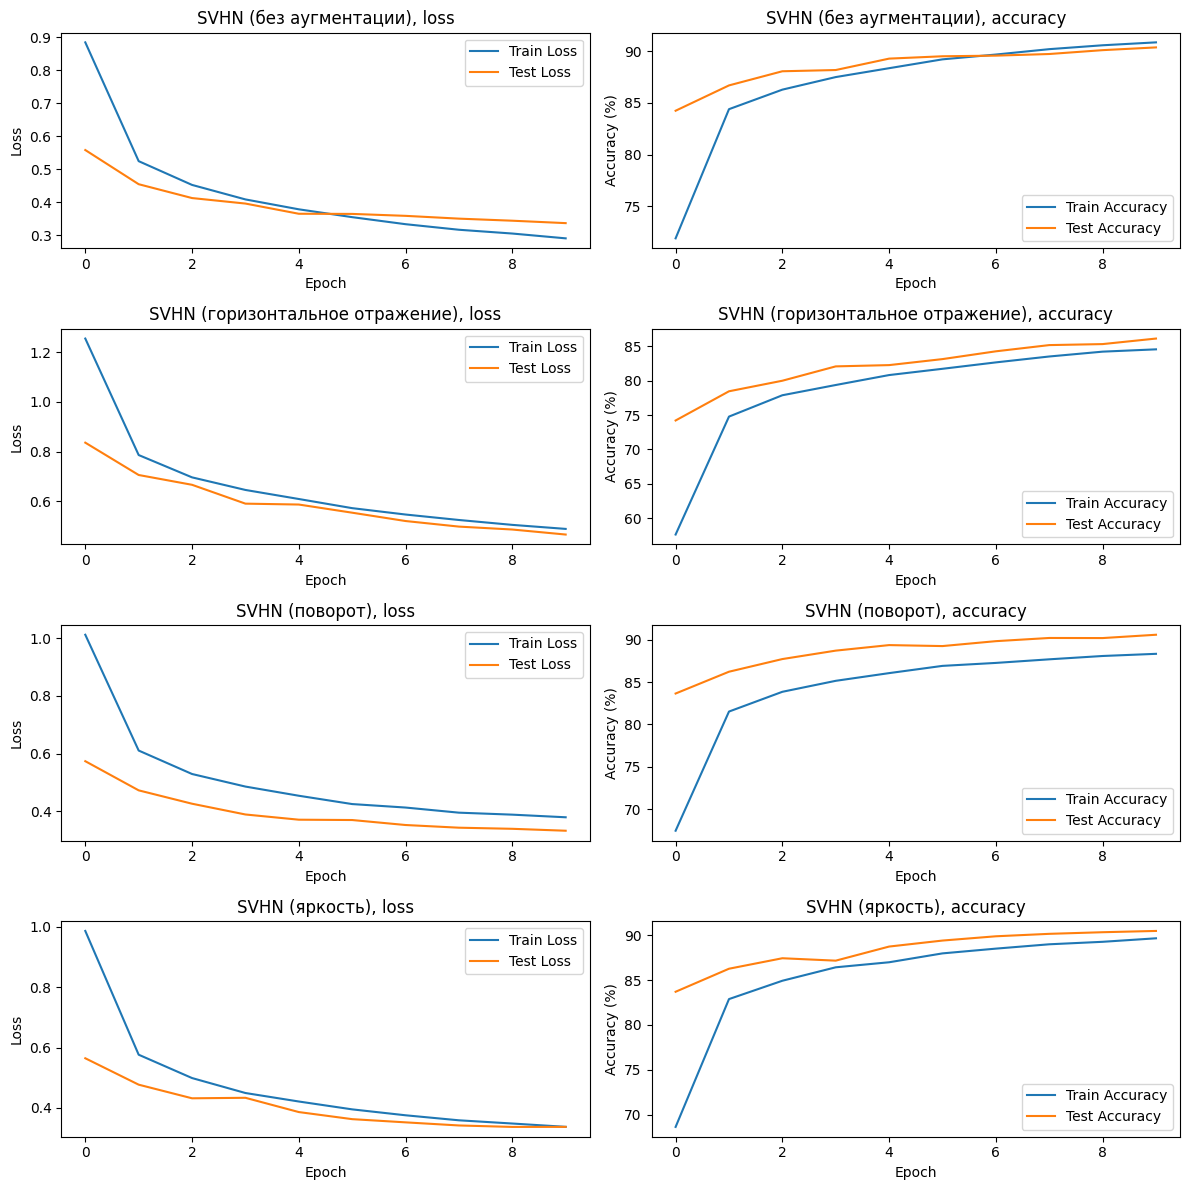

In [ ]:
# Определение пайплайна для аугментации изображений
def get_transforms(augmentation):
    if augmentation == 'без аугментации':
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    elif augmentation == 'горизонтальное отражение':
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    elif augmentation == 'поворот':
        train_transform = transforms.Compose([
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    elif augmentation == 'яркость':
        train_transform = transforms.Compose([
            transforms.ColorJitter(brightness=0.5),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    return train_transform, test_transform

# Определение архитектуры сети
class SimpleCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Загрузка и подготовка датасета SVHN
def load_dataset(train_transform, test_transform):
    trainset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=train_transform)
    testset = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=test_transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)
    return trainloader, testloader

# Тренировочный цикл
def train_model(net, trainloader, testloader, criterion, optimizer, device, num_epochs=10):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Оценка на тестовой выборке
        net.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for data in testloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_loss = test_loss / len(testloader)
        test_accuracy = 100 * correct / total
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Эпоха {epoch + 1}, Потери (train): {train_loss:.3f}, Точность (train): {train_accuracy:.2f}%, Потери (test): {test_loss:.3f}, Точность (test): {test_accuracy:.2f}%')

    # Вычисление метрик
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Для roc_auc_score нужно вычислить вероятности классов
    net.eval()
    all_probs = []
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs = inputs.to(device)
            outputs = net(inputs)
            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())

    all_probs = np.array(all_probs)
    roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')

    metrics = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

    return train_losses, test_losses, train_accuracies, test_accuracies, metrics


# Основная функция для SVHN
def main():
    augmentations = ['без аугментации', 'горизонтальное отражение', 'поворот', 'яркость']
    results = {}

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    for augmentation in augmentations:
        print('\nОбучение на SVHN, аугментация:', augmentation)

        train_transform, test_transform = get_transforms(augmentation)
        trainloader, testloader = load_dataset(train_transform, test_transform)

        input_channels = 3
        num_classes = 10

        net = SimpleCNN(input_channels, num_classes)
        net.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=0.001)

        train_losses, test_losses, train_accuracies, test_accuracies, metrics = train_model(net, trainloader, testloader, criterion, optimizer, device)

        results[augmentation] = {
            'train_losses': train_losses,
            'test_losses': test_losses,
            'train_accuracies': train_accuracies,
            'test_accuracies': test_accuracies,
            'metrics': metrics
        }

    # Вывод метрик
    print("\nМетрики для SVHN:")
    for augmentation in augmentations:
        print(f"Augmentation: {augmentation}")
        metrics = results[augmentation]['metrics']
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1 Score: {metrics['f1']:.4f}")
        print(f"ROC AUC Score: {metrics['roc_auc']:.4f}")

    # Визуализация результатов
    plt.figure(figsize=(12, 12))
    num_augmentations = len(augmentations)

    for j, augmentation in enumerate(augmentations):
        plt.subplot(num_augmentations, 2, j * 2 + 1)
        plt.plot(results[augmentation]['train_losses'], label='Train Loss')
        plt.plot(results[augmentation]['test_losses'], label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'SVHN ({augmentation}), loss')
        plt.legend()

        plt.subplot(num_augmentations, 2, j * 2 + 2)
        plt.plot(results[augmentation]['train_accuracies'], label='Train Accuracy')
        plt.plot(results[augmentation]['test_accuracies'], label='Test Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title(f'SVHN ({augmentation}), accuracy')
        plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

Точность CNN без аугментации на тестовом наборе данных составила 90,35%, **поворот (90,58%) или изменение яркости (90,47%) увеличивают accuracy**, а также метрики precision, recall, F1 score и ROC-AUC. При этом поворот демонстрирует чуть более высокие показатели, но разница небольшая: например, ROC-AUC для CNN с поворотом 0,992, а для модели с изменением яркости 0,9917, поэтому можно сказать, что оба вида аугментации уместны в контексте работы с датасетом SVHN.  
**Горизонтальное отражение** (accuracy = 86,1%), напротив, **снижает точность CNN** на 4,25 п.п., в той же степени сокращает precision, recall и F1 score, а также увеличивает потери модели. Исходя из этого, можно сделать вывод о том, что данный тип аугментации данных не реконмендуется использовать при работе с SVHN.  
Таким образом, **для набора данных SVHN целесообразно применять поворот или изменение яркости**, поскольку оба метода оказывают позитивное воздействие на точность, при этом степень их воздействие не сильно различается.

### Вывод

- *CIFAR-10: горизонтальное отражение.*  
  Датасет CIFAR-10 содержит изображения объектов, существенно отличающихся друг от друга: 10 классов, включающих, как животных и птиц, так и автомобили, самолеты, корабли. Помимо этого, фотографии, представленные в данном наборе, сделаны с различных ракурсов, а следоватольно отражение изображений может помочь модели лучше распознавать объекты, принадлежащие одному классу. Это объясняет, почему для данного датасета наиболее эффективным типом аугментации оказалось горизонталбьное отражение.  

- *Fashion-MNIST: поворот.*  
  Набор данных Fashion-MNIST состоит из однородных черно-белых изображений одежды, что позволяет даже простым CNN эффективно классифицировать такие объекты без аугментации. Однако применение поворота изображений может значительно повысить точность модели и улучшить её обобщающую способность в реальных условиях, где изображения могут быть представлены под различными углами. В то же время, горизонтальное отражение может привести к искажению изображений, а изменение яркости черно-белых объектов может затруднить распознавание текстуры ткани.  

- *SVHN: изменение яркости/поворот.*  
  Датасет SVHN содержит цветные изображения цифр из уличных знаков, которые могут быть сняты в различных условиях освещения. Изменение яркости может поспособствовать адаптации модели к различным условиям освещения и тем самым улучшить её способность к обобщению. Небольшой поворот, в свою очередь, поможет учесть вариации в угле съемки.

## Оптимизация архитектуры CNN


---



**Цель:**  
Изучить влияние изменения количества и размера фильтров, пулинг слоев, Batch Normalization и Dropout на производительность модели CNN. Оценить, как эти изменения влияют на переобучение и обобщающую способность модели.  

**План работы:**  
1.	Создать несколько вариантов CNN с разными архитектурными параметрами (количество фильтров, размеры ядер, использование Batch Normalization и Dropout).
2.	Обучить и сравнить производительность моделей.
3.	Понять, как архитектурные параметры влияют на обобщение и точность модели.  

**Задачи:**  
1.	Создать три варианта архитектуры CNN с разным количеством фильтров и размерами ядер.
2.	Добавить и настроить Batch Normalization и Dropout для предотвращения переобучения.
3.	Провести сравнение моделей по точности и функции потерь на тестовой выборке.
4.	Описать, какой подход лучше работает для данной задачи и почему, предлагая возможные улучшения.

---




Обучение BNDropoutCNN...
Эпоха 1/10, Потери (train): 1.5657, Потери (test): 1.1646, Точность (train): 42.32%, Точность (test): 59.71%, Precision: 0.5986, Recall: 0.5971, F1 Score: 0.5891, ROC AUC: 0.9230
Эпоха 2/10, Потери (train): 1.2852, Потери (test): 1.0305, Точность (train): 53.60%, Точность (test): 63.23%, Precision: 0.6475, Recall: 0.6323, F1 Score: 0.6331, ROC AUC: 0.9368
Эпоха 3/10, Потери (train): 1.1784, Потери (test): 0.9885, Точность (train): 57.75%, Точность (test): 65.99%, Precision: 0.6661, Recall: 0.6599, F1 Score: 0.6551, ROC AUC: 0.9427
Эпоха 4/10, Потери (train): 1.1101, Потери (test): 0.9024, Точность (train): 60.40%, Точность (test): 68.80%, Precision: 0.6868, Recall: 0.6880, F1 Score: 0.6861, ROC AUC: 0.9505
Эпоха 5/10, Потери (train): 1.0543, Потери (test): 0.8900, Точность (train): 62.20%, Точность (test): 68.96%, Precision: 0.6965, Recall: 0.6896, F1 Score: 0.6862, ROC AUC: 0.9528
Эпоха 6/10, Потери (train): 1.0080, Потери (test): 0.9170, Точность (train): 63.

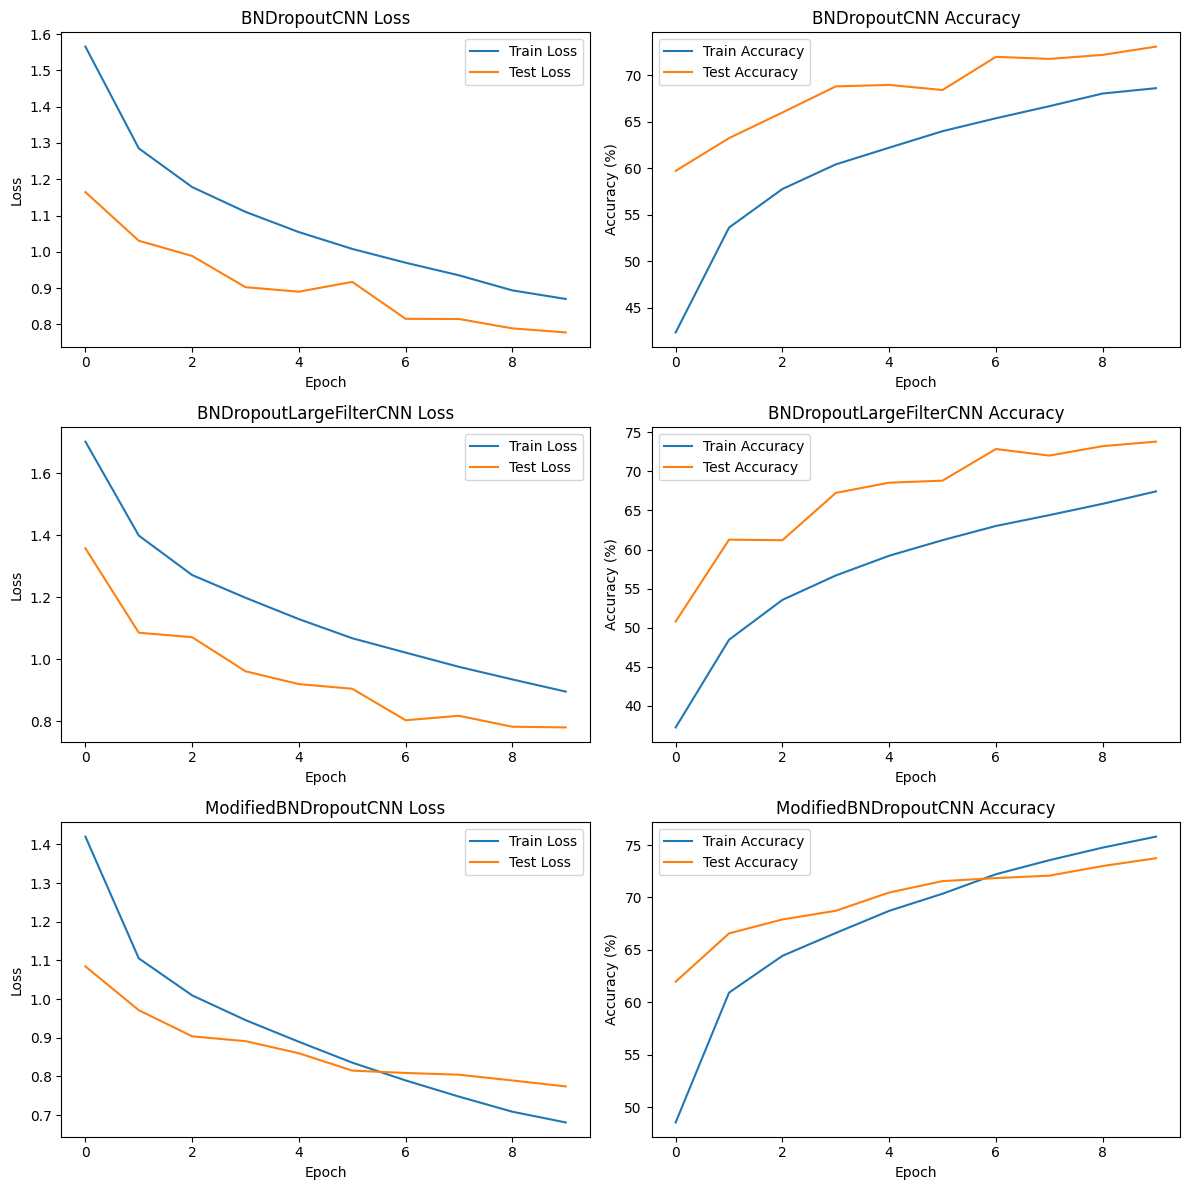

In [ ]:
# Загрузка данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Определение моделей
# CNN с использованием Batch Normalization и Dropout
class BNDropoutCNN(nn.Module):
    def __init__(self):
        super(BNDropoutCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# CNN с увеличенным кол-вом фильтров и размером ядра (с BN и Dropout)
class BNDropoutLargeFilterCNN(nn.Module):
    def __init__(self):
        super(BNDropoutLargeFilterCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)  # Увеличенное количество фильтров и размер ядра
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, padding=2)  # Увеличенное количество фильтров и размер ядра
        self.bn2 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 128 * 8 * 8)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# CNN с BN и Dropout (коэффициент 0,3 вместо 0,5)
class ModifiedBNDropoutCNN(nn.Module):
    def __init__(self):
        super(ModifiedBNDropoutCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Обучение моделей
def train_model(model, train_loader, test_loader, criterion, optimizer, device, epochs=10):
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(100 * correct_train / total_train)

        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        all_labels = []
        all_preds = []
        all_probs = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())
                all_probs.extend(F.softmax(outputs, dim=1).cpu().numpy())
        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(100 * correct_test / total_test)

        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        all_probs = np.array(all_probs)

        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')
        roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')

        metrics = {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc
        }

        print(f'Эпоха {epoch+1}/{epochs}, Потери (train): {train_losses[-1]:.4f}, Потери (test): {test_losses[-1]:.4f}, Точность (train): {train_accuracies[-1]:.2f}%, Точность (test): {test_accuracies[-1]:.2f}%, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}')

    return train_losses, test_losses, train_accuracies, test_accuracies, metrics

# Сравнение моделей
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = [BNDropoutCNN(), BNDropoutLargeFilterCNN(), ModifiedBNDropoutCNN()]
results = {}

for model in models:
    print(f'Обучение {model.__class__.__name__}...')
    model = model.to(device)  # Перемещаем модель на устройство
    train_losses, test_losses, train_accuracies, test_accuracies, metrics = train_model(model, train_loader, test_loader, nn.CrossEntropyLoss(), optim.Adam(model.parameters(), lr=0.001), device)
    results[model.__class__.__name__] = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
        'metrics': metrics
    }

# Вывод метрик
print("\nМетрики для CIFAR-10:")
for model_name in results:
    print('\nМодель:', model_name)
    metrics = results[model_name]['metrics']
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    print(f"ROC AUC Score: {metrics['roc_auc']:.4f}")

# Визуализация результатов
plt.figure(figsize=(12, 12))


for j, model_name in enumerate(results):
    plt.subplot(3, 2, j * 2 + 1)
    plt.plot(results[model_name]['train_losses'], label='Train Loss')
    plt.plot(results[model_name]['test_losses'], label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()

    plt.subplot(3, 2, j * 2 + 2)
    plt.plot(results[model_name]['train_accuracies'], label='Train Accuracy')
    plt.plot(results[model_name]['test_accuracies'], label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{model_name} Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

Наиболее высокую точность продемонстрировала CNN с увеличенным кол-вом фильтров и размером ядра с использованием Batch Normalization и Dropout (0,5)(BNDropoutLargeFilterCNN). Помимо этого, данная модель отличается наиболее высокой метрикой recall.  
- ***Accuracy: 73,82%***  
- Precision: 0,7404  
- ***Recall: 0,7382***  
- F1 Score: 0,7350  
- ROC AUC Score: 0,9626  

Однако метрики precision, F1 score и ROC-AUC выше у модели с Batch Normalization и Dropout с коэффициентом 0,3 (ModifiedBNDropoutCNN).  
- Accuracy: 73,74%  
- ***Precision: 0,7424***  
- Recall: 0,7374  
- ***F1 Score: 0,7359***
- ***ROC AUC Score: 0,9646***  

При этом функция потерь у ModifiedBNDropoutCNN (0,774) ниже, чем у других CNN, а также разница между тренировочной и тестовой точностью у неё самая низкая среди всех моделей.  

Таким образом, BNDropoutLargeFilterCNN демонстрирует лучшую общую точность, однако ModifiedBNDropoutCNN не сильно ей уступает и при этом демонстрирует хорошее обобщение.

## Оптимизация гиперпараметров с использованием нестандартных методов.

---



**Цель:**  
Изучить влияние гиперпараметров, таких как learning rate, batch size и количество слоев. Применить методы циклического темпа обучения, адаптивного learning rate, динамического изменения batch size и анализировать, как эти гиперпараметры влияют на обучение.  

**План работы:**  
1.	Настроить базовый learning rate и batch size, применить Cyclic Learning Rate и Adaptive Learning Rate.
2.	Изучить влияние batch size и количества слоев на обучение.
3.	Сравнить результаты по разным стратегиям и проанализировать, какая оптимизация работает лучше всего.  

**Задачи:**  
1.	Обучить модель с циклическим и адаптивным темпами обучения, сравнить результаты.
2.	Протестировать разные значения batch size и настроить накопление градиентов для экономии памяти.
3.	Сравнить модели с разным количеством фильтров и слоев, чтобы оценить влияние каждого гиперпараметра.
4.	На основе полученных результатов предложить оптимальные настройки гиперпараметров для повышения точности и стабильности обучения.

---




In [ ]:
# Параметры данных
batch_size = 64
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:

# Модель SimpleCNN с гибкими настройками слоев и фильтров
class SimpleCNN(nn.Module):
    def __init__(self, num_layers=2, num_filters=32, num_classes=10):
        super(SimpleCNN, self).__init__()

        # Создаем слои CNN
        self.layers = nn.ModuleList([nn.Conv2d(3, num_filters, kernel_size=3, stride=1, padding=1).to(device)])
        self.layers.extend([nn.Conv2d(num_filters, num_filters, kernel_size=3, stride=1, padding=1).to(device) for _ in range(num_layers - 1)])

        # Пулинг
        self.pool = nn.MaxPool2d(2, 2)

        # Инициализация полносвязного слоя
        self._initialize_fc_layer(num_filters)

    def _initialize_fc_layer(self, num_filters):
        with torch.no_grad():
            x = torch.randn(1, 3, 32, 32, device=device)
            for layer in self.layers:
                x = self.pool(nn.functional.relu(layer(x)))
            self.fc = nn.Linear(x.view(x.size(0), -1).shape[1], 10).to(device)

    def forward(self, x):
        for layer in self.layers:
            x = self.pool(nn.functional.relu(layer(x)))
        x = x.view(x.size(0), -1) # адаптивное настраивание
        x = self.fc(x)
        return x

# Функция тренировки модели с сохранением потерь и точности
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=10):
    train_losses, test_losses = [], []
    train_acc, test_acc = [], []

    for epoch in range(num_epochs):
        model.train()
        correct_train, total_train = 0, 0
        running_train_loss = 0.0
        optimizer.zero_grad()

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()
            if isinstance(scheduler, CyclicLR):
                scheduler.step()

            running_train_loss += loss.item()
            _, predicted = outputs.max(1)
            correct_train += predicted.eq(labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_train_loss / len(train_loader))
        train_acc.append(correct_train / total_train * 100)

        # Тестирование
        model.eval()
        correct_test, total_test = 0, 0
        running_test_loss = 0.0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()
                _, predicted = outputs.max(1)
                correct_test += predicted.eq(labels).sum().item()
                total_test += labels.size(0)

        test_losses.append(running_test_loss / len(test_loader))
        test_acc.append(correct_test / total_test * 100)

        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(test_losses[-1])

    return train_losses, test_losses, train_acc, test_acc

# Параметры эксперимента
learning_rate = 0.001
num_epochs = 10
batch_size = 32

# Конфигурации для экспериментов
layer_configs = [2, 3]  # Количество слоев
filter_configs = [32, 64]  # Количество фильтров
scheduler_types = ['cyclic', 'adaptive']  # Темпы обучения

# Запуск экспериментов и сбор данных
experiment_results = {}

for num_layers in layer_configs:
    for num_filters in filter_configs:
        for scheduler_type in scheduler_types:
            model = SimpleCNN(num_layers=num_layers, num_filters=num_filters).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

            # Настройка планировщика темпа обучения
            if scheduler_type == 'cyclic':
                scheduler = CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, step_size_up=5, mode="triangular2")
            elif scheduler_type == 'adaptive':
                scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3, verbose=False)

            print(f"Обчение модели с {num_layers} слоями, {num_filters} фильтрами, {scheduler_type} scheduler...")

            train_losses, test_losses, train_acc, test_acc = train_model(
                model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs
            )

            experiment_results[(num_layers, num_filters, scheduler_type)] = {
                "train_losses": train_losses,
                "test_losses": test_losses,
                "train_acc": train_acc,
                "test_acc": test_acc
            }

Обчение модели с 2 слоями, 32 фильтрами, cyclic scheduler...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.



Обчение модели с 2 слоями, 32 фильтрами, adaptive scheduler...
Обчение модели с 2 слоями, 64 фильтрами, cyclic scheduler...
Обчение модели с 2 слоями, 64 фильтрами, adaptive scheduler...
Обчение модели с 3 слоями, 32 фильтрами, cyclic scheduler...
Обчение модели с 3 слоями, 32 фильтрами, adaptive scheduler...
Обчение модели с 3 слоями, 64 фильтрами, cyclic scheduler...
Обчение модели с 3 слоями, 64 фильтрами, adaptive scheduler...


In [ ]:
def plot_interactive_results(experiment_results):
    fig = make_subplots(rows=2, cols=4,
                        subplot_titles=[
                            "Loss - 2 слоя, 32 фильтра", "Loss - 2 слоя, 64 фильтра",
                            "Loss - 3 слоя, 32 фильтра", "Loss - 3 слоя, 64 фильтра",
                            "Accuracy - 2 слоя, 32 фильтра", "Accuracy - 2 слоя, 64 фильтра",
                            "Accuracy - 3 слоя, 32 фильтра", "Accuracy - 3 слоя, 64 фильтра"
                        ],
                        vertical_spacing=0.15, horizontal_spacing=0.05)

    row_map = {2: 1, 3: 2}
    col_map = {(2, 32): 1, (2, 64): 2, (3, 32): 3, (3, 64): 4}

    # Цикл по каждой конфигурации
    for num_layers in layer_configs:
        for num_filters in filter_configs:
            for scheduler_type in scheduler_types:
                results = experiment_results[(num_layers, num_filters, scheduler_type)]
                train_losses = results["train_losses"]
                test_losses = results["test_losses"]
                train_acc = results["train_acc"]
                test_acc = results["test_acc"]

                loss_row, acc_row = 1, 2
                col = col_map[(num_layers, num_filters)]

                # График потерь с логарифмической шкалой
                fig.add_trace(go.Scatter(
                    x=list(range(len(train_losses))),
                    y=train_losses,
                    mode="lines",
                    name=f"Train Loss ({scheduler_type})",
                    legendgroup=f"Loss-{num_layers}-{num_filters}",
                    line=dict(dash="solid" if scheduler_type == "cyclic" else "dash")
                ), row=loss_row, col=col)

                fig.add_trace(go.Scatter(
                    x=list(range(len(test_losses))),
                    y=test_losses,
                    mode="lines",
                    name=f"Test Loss ({scheduler_type})",
                    legendgroup=f"Loss-{num_layers}-{num_filters}",
                    line=dict(dash="solid" if scheduler_type == "cyclic" else "dash")
                ), row=loss_row, col=col)

                # График точности
                fig.add_trace(go.Scatter(
                    x=list(range(len(train_acc))),
                    y=train_acc,
                    mode="lines",
                    name=f"Train Acc ({scheduler_type})",
                    legendgroup=f"Acc-{num_layers}-{num_filters}",
                    line=dict(dash="solid" if scheduler_type == "cyclic" else "dash")
                ), row=acc_row, col=col)

                fig.add_trace(go.Scatter(
                    x=list(range(len(test_acc))),
                    y=test_acc,
                    mode="lines",
                    name=f"Test Acc ({scheduler_type})",
                    legendgroup=f"Acc-{num_layers}-{num_filters}",
                    line=dict(dash="solid" if scheduler_type == "cyclic" else "dash")
                ), row=acc_row, col=col)

    # Обновление макета для логарифмической шкалы на графиках потерь
    for col in range(1, 5):
        fig.update_yaxes(type="log", row=1, col=col)

    fig.update_layout(
        title="Сравнение потерь и точности",
        height=900,
        width=1200,
        legend_title="Legend"
    )
    fig.update_xaxes(title_text="Epoch", row=1, col=1)
    fig.update_yaxes(title_text="Loss (Log Scale)", row=1, col=1)
    fig.update_xaxes(title_text="Epoch", row=2, col=1)
    fig.update_yaxes(title_text="Accuracy (%)", row=2, col=1)
    fig.show()

plot_interactive_results(experiment_results)

На графиках видно, что при использовании Adaptive Learning Rate потери моделей выше чем при Cyclic Learning Rate, а accuracy, напротив, очень мала. Данная реализация использует предопределенное количество уровней и фильтров для настройки архитектуры сети, поэтому попробуем поменять подход.

Cyclic Learning Rate
Эпоха [1/20], Потери (train): 1.7057, Точность (train): 40.39%, Потери (test): 1.4788, Точность (test): 47.68%
Эпоха [2/20], Потери (train): 1.3706, Точность (train): 51.83%, Потери (test): 1.2779, Точность (test): 55.20%
Эпоха [3/20], Потери (train): 1.2350, Точность (train): 56.91%, Потери (test): 1.2250, Точность (test): 56.94%
Эпоха [4/20], Потери (train): 1.1425, Точность (train): 60.60%, Потери (test): 1.1458, Точность (test): 61.15%
Эпоха [5/20], Потери (train): 1.0776, Точность (train): 62.97%, Потери (test): 1.1491, Точность (test): 60.34%
Эпоха [6/20], Потери (train): 1.0398, Точность (train): 64.61%, Потери (test): 1.1332, Точность (test): 61.83%
Эпоха [7/20], Потери (train): 0.9886, Точность (train): 66.23%, Потери (test): 1.1875, Точность (test): 59.96%
Эпоха [8/20], Потери (train): 0.9392, Точность (train): 67.87%, Потери (test): 1.1402, Точность (test): 61.57%
Эпоха [9/20], Потери (train): 0.8960, Точность (train): 69.46%, Потери (test): 1.1326, Точн

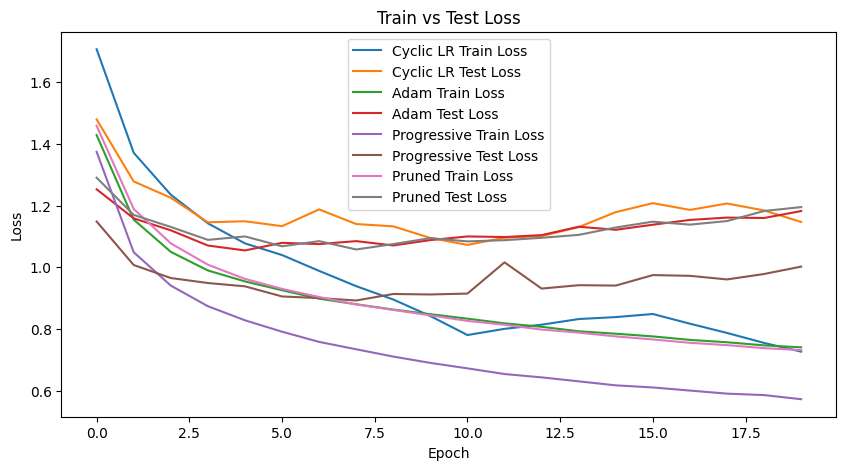

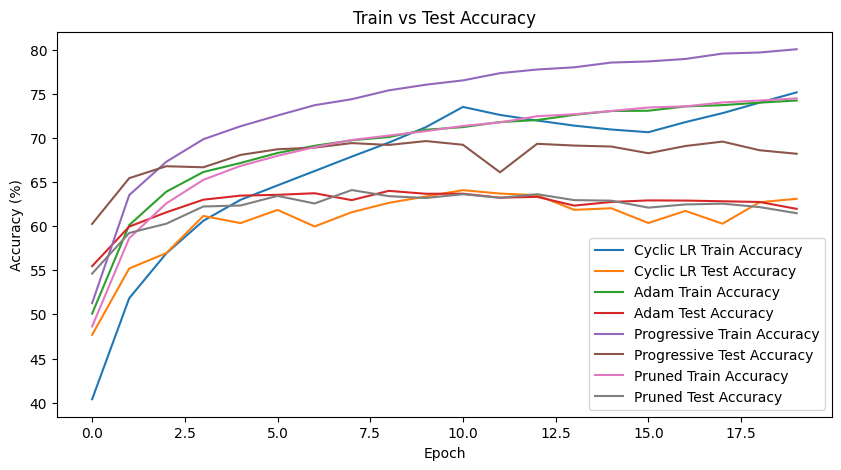

In [ ]:
# Параметры
num_epochs = 20
initial_batch_size = 32
base_lr = 0.001
max_lr = 0.01
accumulation_steps = 4
threshold = 0.2  # для удаления фильтров

# Трансформации и загрузка данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

# Основная модель (Simple CNN)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 16 * 16, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 16 * 16 * 16)
        x = self.fc1(x)
        return x

# Расширенная модель с дополнительным слоем (Extended CNN)
class ExtendedCNN(SimpleCNN):
    def __init__(self):
        super(ExtendedCNN, self).__init__()
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc2 = nn.Linear(32 * 8 * 8, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 32 * 8 * 8)
        x = self.fc2(x)
        return x

# Функция для обучения модели
def train_model(model, optimizer, train_loader, test_loader, scheduler=None, accumulation_steps=1):
    model.train()
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, (inputs, labels) in enumerate(train_loader):
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()

            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Обновление learning rate при использовании CyclicLR
        if scheduler:
            scheduler.step()

        # Train Loss и Accuracy
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(100 * correct_train / total_train)

        # Test Loss и Accuracy
        test_loss, test_accuracy = evaluate_model(model, test_loader)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f"Эпоха [{epoch + 1}/{num_epochs}], Потери (train): {train_losses[-1]:.4f}, "
              f"Точность (train): {train_accuracies[-1]:.2f}%, Потери (test): {test_losses[-1]:.4f}, "
              f"Точность (test): {test_accuracies[-1]:.2f}%")

    return train_losses, test_losses, train_accuracies, test_accuracies

# Функция для тестирования модели
def evaluate_model(model, loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(loader), 100 * correct / total

# Функция для удаления неактивных фильтров
def prune_filters(model, threshold=0.1):
    for name, param in model.named_parameters():
        if "weight" in name:
            param.data = F.dropout(param.data, p=threshold)

# Тренировка и сбор метрик
train_loader = DataLoader(train_data, batch_size=initial_batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)

print("Cyclic Learning Rate")
model = SimpleCNN()
optimizer = optim.SGD(model.parameters(), lr=base_lr, momentum=0.9)
scheduler = CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr, step_size_up=5, mode="triangular2")
cyclic_lr_train_losses, cyclic_lr_test_losses, cyclic_lr_train_acc, cyclic_lr_test_acc = train_model(
    model, optimizer, train_loader, test_loader, scheduler)

print("\nAdaptive Learning Rate (Adam)")
model = SimpleCNN()
optimizer = optim.Adam(model.parameters(), lr=base_lr)
adam_train_losses, adam_test_losses, adam_train_acc, adam_test_acc = train_model(
    model, optimizer, train_loader, test_loader)

print("\nProgressive Layer Growth")
model = ExtendedCNN()
optimizer = optim.Adam(model.parameters(), lr=base_lr)
progressive_train_losses, progressive_test_losses, progressive_train_acc, progressive_test_acc = train_model(
    model, optimizer, train_loader, test_loader)

print("\nFilter Pruning")
model = SimpleCNN()
prune_filters(model, threshold=threshold)
optimizer = optim.Adam(model.parameters(), lr=base_lr)
pruned_train_losses, pruned_test_losses, pruned_train_acc, pruned_test_acc = train_model(
    model, optimizer, train_loader, test_loader)

# Визуализация потерь
plt.figure(figsize=(10, 5))
plt.plot(cyclic_lr_train_losses, label="Cyclic LR Train Loss")
plt.plot(cyclic_lr_test_losses, label="Cyclic LR Test Loss")
plt.plot(adam_train_losses, label="Adam Train Loss")
plt.plot(adam_test_losses, label="Adam Test Loss")
plt.plot(progressive_train_losses, label="Progressive Train Loss")
plt.plot(progressive_test_losses, label="Progressive Test Loss")
plt.plot(pruned_train_losses, label="Pruned Train Loss")
plt.plot(pruned_test_losses, label="Pruned Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Train vs Test Loss")
plt.show()

# Визуализация точности
plt.figure(figsize=(10, 5))
plt.plot(cyclic_lr_train_acc, label="Cyclic LR Train Accuracy")
plt.plot(cyclic_lr_test_acc, label="Cyclic LR Test Accuracy")
plt.plot(adam_train_acc, label="Adam Train Accuracy")
plt.plot(adam_test_acc, label="Adam Test Accuracy")
plt.plot(progressive_train_acc, label="Progressive Train Accuracy")
plt.plot(progressive_test_acc, label="Progressive Test Accuracy")
plt.plot(pruned_train_acc, label="Pruned Train Accuracy")
plt.plot(pruned_test_acc, label="Pruned Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Train vs Test Accuracy")
plt.show()

Анализ результатов и сравнительное исследование моделей с различными гиперпараметрами, такими как количество фильтров и слоев, позволяет сделать несколько выводов и предложений по улучшению производительности.

**Основные наблюдения:**
1. **Cyclic Learning Rate**: Динамика обучения выглядит положительно, с постепенным снижением ошибки на тренировочных данных. Однако на тестовой выборке появляется явное переобучение после 10-11 эпох, когда Test Loss начинает увеличиваться, а Test Accuracy стабилизируется на уровне около 63%.
2. **Adaptive Learning Rate (Adam)**:
Обучение проходит стабильно, но точность на тестовой выборке увеличивается лишь немного (~63% в конце обучения). Test Loss растет после 6 эпох, что может указывать на начало переобучения. Adam достигает лучшего баланса между скоростью сходимости и точностью по сравнению с Cyclic Learning Rate, однако имеет склонность "застревать" в локальных минимумах.
3. **Progressive Layer Growth**:
Данный подход демонстрирует наилучшую точность на тестовой выборке (до 69%) по сравнению с другими методами. Постепенное добавление слоев улучшает способность модели к обучению, что позволяет сохранить низкую Test Loss до 10 эпох. Тем не менее, после 10 эпох возникает слабое переобучение.
4. **Filter Pruning:**
Использование меньшего числа фильтров приводит к снижению общей производительности модели. Максимальная Test Accuracy составляет около 62.37%, что указывает на недостаточную мощность модели для решения задачи.

**Влияние гиперпараметров:**
- Количество слоев (Progressive Layer Growth): Добавление слоев улучшает результаты, особенно при большом объеме данных и подходящей регуляризации.
- Количество фильтров (Filter Pruning): Снижение числа фильтров приводит к снижению производительности, что особенно заметно на Test Loss и Test Accuracy. Для сложных задач стоит использовать большее количество фильтров.
- Переобучение: Проблемы с переобучением наблюдаются во всех подходах после определенного количества эпох, что подчеркивает необходимость ранней остановки или регуляризации (например, Dropout или Weight Decay).

**Рекомендации по оптимальным гиперпараметрам:**

* Обучение:

  * Использовать Adam для начального этапа обучения, а Cyclic Learning Rate — для последующей тонкой настройки.
  *Включить раннюю остановку, чтобы избежать переобучения, с учетом метрик валидации.

* Количество слоев:

  * Применять Progressive Layer Growth, добавляя 2-3 дополнительных слоя, особенно при сложных данных.

* Количество фильтров:

  * Избегать уменьшения фильтров ниже оптимального уровня (например, 64, 128 или 256 для ConvNet).

* Регуляризация:

  * Применять Dropout с вероятностью 0.4-0.5 для предотвращения переобучения.
  * Использовать L2-регуляризацию (Weight Decay около 0.0001).

* Длительность обучения:

  * Останавливать обучение на этапе увеличения Test Loss (с ранней остановкой, например, с patience=5 эпох).

* Дополнительные эксперименты:

  * Попробовать использовать Batch Normalization для улучшения сходимости и стабильности обучения.
  * Увеличить размер мини-батча (batch size) для более стабильного обучения.
